In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from spacy.lang.en import English
from collections import Counter
from string import punctuation
from nltk import word_tokenize
import pandas as pd
#import altair as alt
import numpy as np
import gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/chinguyen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chinguyen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# 0. Set up allegations data from csv #
#
# read in csv
narratives_csv_url = "https://raw.githubusercontent.com/andresnigenda/cpd_complaints_nlp/master/src/unsupervised/narratives.csv"
df = pd.read_csv(narratives_csv_url)
# filter to relevant section
df = df[df.column_name == "Initial / Intake Allegation"]
#we want to keep rows with unique content for cr_id and text
# filter to relevant columns
df = df[['cr_id', 'text']]
print("There are {} complaints".format(df.shape[0]))
# drop allegations with same id + text
df = df.drop_duplicates(['cr_id', 'text'])
print("There are {} unique complaints".format(df.shape[0]))
#allegations_lst = df['text'].to_list()
df.head()

There are 19966 complaints
There are 17001 unique complaints


,cr_id,text
0,1048960,The reporting party alleges that the\naccused ...
4,1048962,The victim alleges that an unknown male\nblack...
9,1048964,The reporting party alleges that he was a\nvi...
12,1048965,The reporting party alleges that while\nwaitin...
14,1048965,The reporting party alleges that while\nwaitin...


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim_vectors(vec1, vec2):
  vec1 = vec1.reshape(1,-1)
  vec2 = vec2.reshape(1,-1)
  return cosine_similarity(vec1, vec2)[0][0]

def split_half_and_compare(str_input):
  if len(str_input) < 2 or str_input in ['nfi', 'NFI'] or str_input in nltk.corpus.stopwords.words('english'):
    return False
  first_half = str_input[0:len(str_input)//2] 
  second_half = str_input[len(str_input)//2 if len(str_input)%2 == 0
                                 else ((len(str_input)//2)+1):]
  #print(first_half)
  #print(second_half)
  vectorizer = CountVectorizer().fit_transform([first_half, second_half])
  vectors = vectorizer.toarray()
  similarity_score = cosine_sim_vectors(vectors[0], vectors[1])
  #print(similarity_score)
  return similarity_score > .9

In [0]:
df['DuplicateText'] = df['text'].apply(split_half_and_compare)
duplicated_df = df[df['DuplicateText'] == True].reset_index()
df['text'] = df.apply(lambda row: row['text'] if row['DuplicateText'] == False else row['text'][0:len(row['text'])//2], axis=1)

In [0]:
def convert_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
df_sentences = df.text.values.tolist()
df_words = list(convert_to_words(df_sentences))
#Check the first 2 sentences
print(df_words[:2])

[['the', 'reporting', 'party', 'alleges', 'that', 'the', 'accused', 'officer', 'was', 'rude', 'and', 'unprofessional', 'during', 'traffic', 'stop', 'the', 'accused', 'officer', 'threatened', 'to', 'place', 'her', 'in', 'handcuffs', 'and', 'failed', 'to', 'inform', 'the', 'complainant', 'as', 'to', 'why', 'she', 'was', 'being', 'stopped', 'the', 'reporting', 'party', 'further', 'alleges', 'that', 'the', 'officer', 'stated', 'license', 'and', 'registration', 'now', 'before', 'snatch', 'you', 'out', 'of', 'this', 'car', 'and', 'put', 'you', 'in', 'handcuffs'], ['the', 'victim', 'alleges', 'that', 'an', 'unknown', 'male', 'black', 'off', 'duty', 'officer', 'threw', 'her', 'against', 'the', 'wall', 'after', 'she', 'did', 'not', 'adhere', 'to', 'his', 'command', 'to', 'get', 'up', 'the', 'victim', 'alleges', 'that', 'the', 'officer', 'pushed', 'her', 'face', 'against', 'the', 'wall', 'and', 'handcuffed', 'her', 'too', 'tightly']]


In [0]:
#Construct the list of stop words that contains common English stop words
#and specific stop words from data
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
additional_stopwords = list(set(["accused", "reporting", "party", "alleges", "officer", 
                        "alleged", "alleges", "complainant", "officers", "victim", 
                        "police", "stated", "report", "states", "called", 
                        "did", "told", "provide", "incident", "regarding", "issued",
                        "reported", "vehicle", "car", "justification",
                        "district", "uniformed", "threatened", "witness", "th",
                        "number", "scene"]))
STOP_WORDS.extend(additional_stopwords)

Code sources:
Building LDA model: 
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Data Visualization: 
https://datascienceplus.com/topic-modeling-in-python-with-nltk-and-gensim/

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [0]:
# Build the bigram and trigram models
bigram = Phrases(df_words, min_count=5, threshold=100)
trigram = Phrases(bigram[df_words], threshold=100)  
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once

def remove_stopwords(texts):
    '''
    Loop through each document and use simple_preprocess() to convert each document
    Then loop through each word in the document and remove stop words
    Return a list of list of words 
    '''
    return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]    

def process_words(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    https://spacy.io/api/annotation
    """
    texts = remove_stopwords(texts)
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = remove_stopwords(texts_out)   
    return texts_out

lemmatized_data = process_words(df_words)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Generate data visualizations to evaluate model results

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def generate_word_cloud(model, num_topics):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

  cloud = WordCloud(stopwords=STOP_WORDS,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=20,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = model.show_topics(formatted=False)

  fig, axes = plt.subplots(int(num_topics), 1, figsize=(15,15), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()

Create a function to display dominant topic for each document

In [0]:
def get_topics_df(lda_model, corpus, texts):
    #initialize an empty dataframe
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row_list in enumerate(lda_model[corpus]):
        row = row_list
        if lda_model.per_word_topics:
          row = row_list[0]      
        # each row contains a list of tuple with topic number and percent contribution of each keyword 
        # sort the tuple (topic number, keywords) in a row by percent contribution
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the the dominant topic, percent contribution and list of keywords for each document
        #first element is the dominant topic with highest contribution percent
        (dominant_topic_num, dominant_topic_prop) = row[0]
        
        #lda_model.show_topic() returns a list of tuples (keyword, percent contribution)
        topic_keyword_pct_list = lda_model.show_topic(dominant_topic_num)
        topic_keywords = ", ".join([word for word, _ in topic_keyword_pct_list])
        
        #add to the df
        topics_df = topics_df.append(pd.Series([int(dominant_topic_num), 
                                                round(dominant_topic_prop,2), 
                                                topic_keywords]), 
                                     ignore_index=True)
    # Add original text to the end of the output
    original_text = pd.Series(texts)
    topics_df = pd.concat([topics_df, original_text], axis=1)
    return topics_df

In [0]:
from matplotlib.ticker import FuncFormatter

# Dominant Topics in Each Document
def get_doc_cnt_per_topic(dominant_topic_df):
  dominant_topic = dominant_topic_df[['Document_Number', 'Dominant_Topic']]
  doc_cnt_per_topic = dominant_topic.groupby('Dominant_Topic').size()
  doc_cnt_per_topic = doc_cnt_per_topic.to_frame(name='count').reset_index()
  return doc_cnt_per_topic

def bar_chart_doc_by_topic(model, doc_cnt_per_topic):
  # Plot
  fig, ax = plt.subplots(figsize=(12, 8))

  # Number of Documents by Dominant Topics
  ax.bar(x='Dominant_Topic', height='count', data=doc_cnt_per_topic, width=.5, color='purple')
  ax.set_xticks(range(doc_cnt_per_topic.Dominant_Topic.unique().__len__()))
  #tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
  #plt.xaxis.set_major_formatter(tick_formatter)
  ax.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=20))
  ax.set_xlabel('Topic', fontsize=15)
  ax.set_ylabel('Number of Documents', fontsize=15)
  ax.set_ylim(0, 8000)

  plt.show()

def get_topic_words(dominant_topic_df):
  topic_words = dominant_topic_df[['Dominant_Topic', 'Keywords']]
  topic_words.drop_duplicates(inplace=True)
  topic_words.sort_values(by='Dominant_Topic', ascending=True, inplace=True)
  return topic_words

In [0]:
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

#Build the model and evaluate
def build_and_evaluate(data_input, num_topics):
  print("Number of topics: {}".format(num_topics))
  # Create Dictionary
  id2word = corpora.Dictionary(lemmatized_data)

  # Create Corpus: Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in lemmatized_data]

  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=100,
                                              update_every=1,
                                              chunksize=10,
                                              passes=10,
                                              alpha='symmetric',
                                              iterations=100,
                                              per_word_topics=True)
  print("Printing topics....")
  print(lda_model.print_topics())

  dominant_topic_df = get_topics_df(lda_model, corpus, lemmatized_data).reset_index()
  dominant_topic_df.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Contribution(%)', 'Keywords', 'Original_Text']
  print("Printing dominant topic dataframe....")
  print(dominant_topic_df.head(20))

  print("")
  print("Data Visualization....")
  doc_cnt_per_topic = get_doc_cnt_per_topic(dominant_topic_df)
  bar_chart_doc_by_topic(lda_model, doc_cnt_per_topic)
  topic_words = get_topic_words(dominant_topic_df)
  print(topic_words)
  print("")
  return lda_model

Number of topics: 4
Printing topics....
[(0, '0.038*"go" + 0.037*"citation" + 0.023*"place" + 0.020*"property" + 0.019*"several" + 0.018*"station" + 0.017*"leave" + 0.015*"false" + 0.014*"identify" + 0.014*"gun"'), (1, '0.082*"arrest" + 0.081*"fail" + 0.036*"male" + 0.026*"unknown" + 0.024*"return" + 0.023*"falsely" + 0.018*"subject" + 0.017*"respond" + 0.017*"refuse" + 0.017*"inventory"'), (2, '0.074*"search" + 0.029*"residence" + 0.026*"also" + 0.025*"take" + 0.025*"time" + 0.025*"call" + 0.021*"warrant" + 0.019*"drive" + 0.017*"drug" + 0.017*"question"'), (3, '0.050*"stop" + 0.032*"traffic" + 0.024*"phone" + 0.024*"case" + 0.020*"inform" + 0.020*"rude" + 0.019*"order" + 0.019*"driver" + 0.017*"license" + 0.016*"inventorie"')]
Printing dominant topic dataframe....
    Document_Number  ...                                      Original_Text
0                 0  ...  [rude, unprofessional, traffic, stop, place, h...
1                 1  ...  [unknown, male, black, duty, throw, get, push

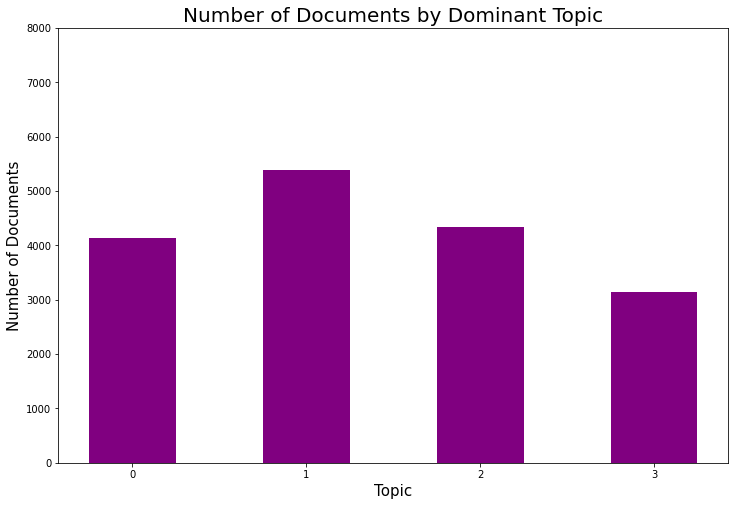

   Dominant_Topic                                           Keywords
7             0.0  go, citation, place, property, several, statio...
1             1.0  arrest, fail, male, unknown, return, falsely, ...
5             2.0  search, residence, also, take, time, call, war...
0             3.0  stop, traffic, phone, case, inform, rude, orde...

Number of topics: 10
Printing topics....
[(0, '0.045*"leave" + 0.039*"identify" + 0.036*"duty" + 0.035*"inventorie" + 0.029*"city" + 0.027*"ticket" + 0.026*"walk" + 0.023*"key" + 0.022*"use" + 0.022*"release"'), (1, '0.056*"several" + 0.046*"false" + 0.043*"gun" + 0.038*"say" + 0.036*"strike" + 0.035*"personal" + 0.033*"hispanic" + 0.029*"reason" + 0.026*"floor" + 0.025*"plainclothe"'), (2, '0.070*"also" + 0.069*"time" + 0.047*"drug" + 0.041*"ask" + 0.032*"harass" + 0.025*"make" + 0.025*"child" + 0.024*"look" + 0.023*"come" + 0.022*"may"'), (3, '0.112*"citation" + 0.060*"property" + 0.057*"case" + 0.047*"rude" + 0.040*"female" + 0.032*"unprofessi

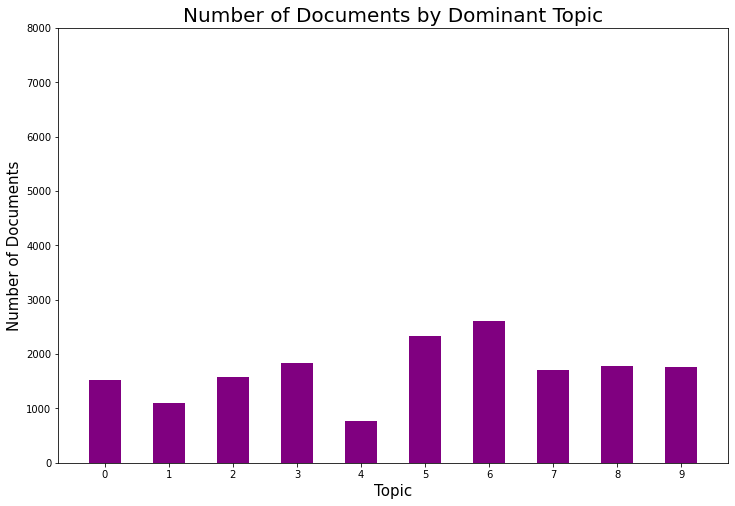

    Dominant_Topic                                           Keywords
7              0.0  leave, identify, duty, inventorie, city, ticke...
17             1.0  several, false, gun, say, strike, personal, hi...
9              2.0  also, time, drug, ask, harass, make, child, lo...
3              3.0  citation, property, case, rude, female, unprof...
15             4.0  falsely, subject, son, side, listen, illegally...
11             5.0  arrest, search, return, warrant, inventory, dr...
2              6.0  fail, residence, call, time, file, service, in...
1              7.0  male, go, unknown, remove, front, black, white...
5              8.0  refuse, take, respond, question, station, neig...
0              9.0  stop, traffic, place, phone, inform, license, ...

Number of topics: 14
Printing topics....
[(0, '0.103*"male" + 0.081*"stop" + 0.077*"go" + 0.076*"unknown" + 0.052*"traffic" + 0.046*"place" + 0.032*"black" + 0.032*"inform" + 0.032*"white" + 0.028*"license"'), (1, '0.289*"search"

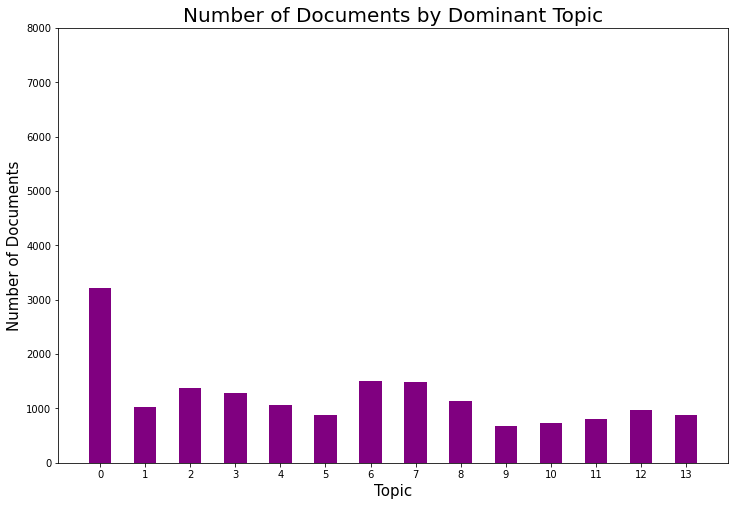

    Dominant_Topic                                           Keywords
0              0.0  male, stop, go, unknown, traffic, place, black...
58             1.0  search, phone, door, person, attempt, cellular...
9              2.0  residence, also, offender, harass, make, child...
3              3.0  time, call, rude, back, unprofessional, fuckin...
29             4.0  order, home, apartment, enter, hour, strike, p...
17             5.0  drive, damage, side, listen, story, daughter, ...
2              6.0  refuse, case, file, give, neighbor, arrive, fe...
19             7.0  citation, return, warrant, inventory, property...
5              8.0  take, respond, question, station, information,...
43             9.0  son, inventorie, say, look, girlfriend, effect...
40            10.0  front, pull, detain, hispanic, ticket, release...
62            11.0  subject, remove, drug, several, ask, false, id...
7             12.0  fail, leave, duty, city, action, miss, year, a...
13            13.0  

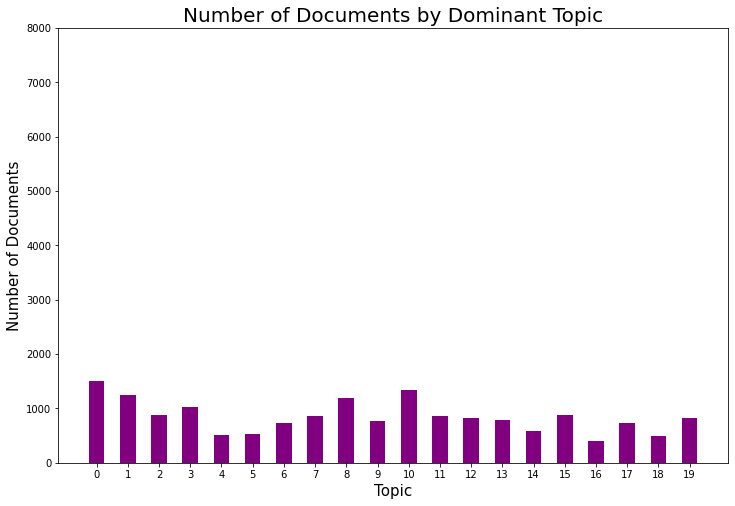

    Dominant_Topic                                           Keywords
22             0.0  residence, offender, enter, obtain, break, dom...
11             1.0  search, phone, door, damage, home, person, car...
9              2.0  pull, ticket, park, issue, away, know, involve...
17             3.0  son, several, white, side, listen, story, hisp...
15             4.0  remove, front, apartment, detain, hour, person...
97             5.0  street, failed, try, fight, failure, vicinity,...
13             6.0  false, driver, gun, say, contain, cell, note, ...
76             7.0  arrest, falsely, illegally, batter, set, secur...
5              8.0  refuse, respond, question, information, neighb...
35             9.0  call, property, case, service, assistance, cit...
0             10.0  fail, stop, traffic, place, drug, inform, lice...
19            11.0  return, subject, warrant, inventory, drive, st...
7             12.0  go, order, station, leave, duty, wallet, use, ...
2             13.0  

In [0]:
model_list = []
for num_topics in [4, 10, 14, 20]:
  lda_model = build_and_evaluate(lemmatized_data, num_topics)
  model_list.append(lda_model)

In [0]:
model_list

In [0]:
import pyLDAvis.gensim

id2word = corpora.Dictionary(lemmatized_data)
corpus = [id2word.doc2bow(text) for text in lemmatized_data]
pyLDAvis.enable_notebook()
first_model = model_list[0]
vis = pyLDAvis.gensim.prepare(first_model, corpus, dictionary=first_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.303567 -0.172817       1        1  29.723967
2      0.094224  0.314295       2        1  26.371870
0     -0.219945  0.054957       3        1  23.644279
3     -0.177845 -0.196436       4        1  20.259882, topic_info=         Term         Freq        Total Category  logprob  loglift
79     arrest  4930.000000  4930.000000  Default  30.0000  30.0000
0        fail  4882.000000  4882.000000  Default  29.0000  29.0000
78     search  3970.000000  3970.000000  Default  28.0000  28.0000
9        stop  2053.000000  2053.000000  Default  27.0000  27.0000
60         go  1818.000000  1818.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
181    street   365.707367   366.827942   Topic4  -4.7227   1.5935
256   contact   329.633759   330.709595   Topic4  -4.8265   1.5933
361  involved   320.983337   322.059540   Topic4  -4.8531   1.5932
604   include   311.969818   313.151611   Topic4  -4.8816   1.5927
243     order   791.675049   915.953369   Topic4  -3.9504   1.4507

[164 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
364       4  0.997912   accident
275       4  0.997555      allow
151       2  0.999187       also
530       3  0.998075     amount
276       2  0.998539  apartment
...     ...       ...        ...
118       2  0.999183    warrant
375       1  0.998152      white
666       2  0.003145       year
666       3  0.993753       year
666       4  0.003145       year

[149 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [0]:
second_model = model_list[1]
second_vis = pyLDAvis.gensim.prepare(second_model, corpus, dictionary=second_model.id2word)
second_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.353371  0.067640       1        1  13.573498
7      0.116888 -0.041281       2        1  12.193966
5      0.114175  0.416257       3        1  11.246297
2     -0.208421 -0.018745       4        1  11.039719
8      0.061297 -0.048676       5        1  10.969051
9      0.061782 -0.053441       6        1   9.213387
3      0.042942 -0.100473       7        1   8.741549
1      0.059388 -0.081109       8        1   8.426443
0      0.040218 -0.073812       9        1   8.175779
4      0.065100 -0.066362      10        1   6.420318, topic_info=           Term         Freq        Total Category  logprob  loglift
0          fail  5089.000000  5089.000000  Default  30.0000  30.0000
79       arrest  4201.000000  4201.000000  Default  29.0000  29.0000
78       search  3133.000000  3133.000000  Default  28.0000  28.0000
16         male  2405.000000  2405.000000  Default  27.0000  27.0000
9          stop  2065.000000  2065.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
731       entry    96.469284    97.714294  Topic10  -4.9061   2.7329
307     message    94.664139    95.909225  Topic10  -4.9250   2.7326
475        girl    97.880135    99.201561  Topic10  -4.8916   2.7323
1170  impounded   116.431061   118.068954  Topic10  -4.7181   2.7317
892      escape   163.347549   167.715408  Topic10  -4.3795   2.7193

[337 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
364       6  0.997391    accident
755       9  0.994872      action
3418      7  0.994012  afterwards
275       5  0.998019       allow
911       3  0.993191      almost
...     ...       ...         ...
466      10  0.994807        word
163       4  0.997131       would
1719      7  0.994732        yard
666       2  0.996128        year
229       9  0.994685        yell

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 3, 9, 10, 4, 2, 1, 5])

In [0]:
third_model = model_list[2]
third_vis = pyLDAvis.gensim.prepare(third_model, corpus, dictionary=third_model.id2word)
third_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.104853 -0.187115       1        1  12.040208
2      0.105395  0.082483       2        1   8.942926
8      0.069664  0.008295       3        1   8.089636
6      0.087569 -0.100528       4        1   7.892583
4      0.018971  0.063817       5        1   7.357384
3      0.151246  0.058340       6        1   7.325202
11    -0.078211  0.019316       7        1   7.097809
7     -0.308163  0.089668       8        1   6.605856
5      0.059140 -0.008524       9        1   6.471433
12    -0.202714 -0.162470      10        1   6.452713
13    -0.052187 -0.227077      11        1   5.916239
1     -0.062926  0.230806      12        1   5.847144
10     0.026968  0.040976      13        1   5.024826
9      0.080395  0.092012      14        1   4.936044, topic_info=         Term         Freq        Total Category  logprob  loglift
0        fail  4696.000000  4696.000000  Default  30.0000  30.0000
79     arrest  3875.000000  3875.000000  Default  29.0000  29.0000
78     search  3429.000000  3429.000000  Default  28.0000  28.0000
162      time  2518.000000  2518.000000  Default  27.0000  27.0000
16       male  2524.000000  2524.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
412   trouble    83.712616    84.942902  Topic14  -4.7851   2.9940
2277   murder    82.164864    83.395142  Topic14  -4.8037   2.9937
368    happen    77.299080    78.529381  Topic14  -4.8648   2.9928
3549  essence    89.035973    90.514297  Topic14  -4.7234   2.9921
1398      kid   104.456741   107.054436  Topic14  -4.5637   2.9840

[464 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4488     11  0.972089   abandon
854      11  0.977243      able
364       1  0.996994  accident
1517      9  0.989150   account
755      10  0.995295    action
...     ...       ...       ...
1719      4  0.992369      yard
666      10  0.996006      year
229      13  0.990505      yell
2036      6  0.985370   yelling
2022      4  0.990316     young

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 9, 7, 5, 4, 12, 8, 6, 13, 14, 2, 11, 10])

In [0]:
fourth_model = model_list[3]
fourth_vis = pyLDAvis.gensim.prepare(fourth_model, corpus, dictionary=fourth_model.id2word)
fourth_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.326717  0.066996       1        1  7.202319
19    -0.046240  0.154950       2        1  6.625137
8     -0.078568  0.020984       3        1  6.311818
3     -0.039223  0.175398       4        1  6.064198
12    -0.102932  0.064255       5        1  5.878836
1     -0.046210  0.107306       6        1  5.368329
13    -0.025156 -0.059597       7        1  5.331452
14    -0.055092 -0.087388       8        1  5.260266
11     0.033733  0.201025       9        1  5.155395
17    -0.083098 -0.122635      10        1  5.023731
6      0.121515 -0.061692      11        1  4.984094
18    -0.032422 -0.059218      12        1  4.673723
0     -0.119733  0.025311      13        1  4.669534
2      0.003636  0.004089      14        1  4.468453
15     0.067165 -0.117097      15        1  4.468227
7      0.190313  0.011396      16        1  4.364995
9     -0.007374 -0.182134      17        1  4.207678
4     -0.109134  0.046820      18        1  3.751479
5      0.006372 -0.062039      19        1  3.115297
16    -0.004271 -0.126729      20        1  3.075050, topic_info=              Term         Freq        Total Category  logprob  loglift
0             fail  4862.000000  4862.000000  Default  30.0000  30.0000
79          arrest  3793.000000  3793.000000  Default  29.0000  29.0000
78          search  3239.000000  3239.000000  Default  28.0000  28.0000
16            male  2530.000000  2530.000000  Default  27.0000  27.0000
162           time  2135.000000  2135.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4592        tamper    44.078468    45.383457  Topic20  -4.9532   3.4527
1613         third    41.288357    42.566048  Topic20  -5.0186   3.4514
3798         brain    64.366104    66.494553  Topic20  -4.5746   3.4493
6437        spoken    96.368340   102.858185  Topic20  -4.1710   3.4167
6791  indebtedness   122.134270   212.672531  Topic20  -3.9341   2.9272

[665 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4488     11  0.989175   abandon
854      15  0.987540      able
3013     17  0.954953  abruptly
364       1  0.997210  accident
3802      3  0.561899    accost
...     ...       ...       ...
1719      3  0.991279      yard
666       8  0.995123      year
229      14  0.993378      yell
2036      7  0.982538   yelling
2022      7  0.987476     young

[805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 20, 9, 4, 13, 2, 14, 15, 12, 18, 7, 19, 1, 3, 16, 8, 10, 5, 6, 17])